In [14]:
import os
import sys
sys.path.append('../')
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.utils import *
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

%matplotlib inline

In [15]:
IP_pad = np.zeros((2552, 2552))
IP_pad[1276, 1276] = 1

In [16]:
pathname = gettempdir()

PML_size = 4 # 12                               # Size of the PML in grid points.
Nx, Ny = IP_pad.shape
R_ring = 0.05                               # Radius of the ring array [m].
dx, dy = 4.e-5, 4.e-5                       # Grid point spacing in the y direction [m].
T_sample = 1/80e6                           # Sample time step [s].

N_transducer = 512                          # Number of transducers in ring array.
center_pos = [0, 0]
arc_angle = 2 * np.pi
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

In [17]:
v0 = 1500.0
SoS = np.ones((Ny, Nx)) * v0
rou = 1000  # Density.
medium = kWaveMedium(sound_speed=SoS, sound_speed_ref=v0, density=rou)

In [18]:
source = kSource()
source.p0 = IP_pad

# Smooth the initial pressure distribution and restore the magnitude.
# source.p0 = smooth(source.p0, True)

cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# Create the time array.
kgrid.makeTime(medium.sound_speed)
kgrid.setTime(4000, T_sample) ##

# Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, f'example_input.h5'),
    'SaveToDiskExit': False,
}

# Run the simulation.
sensor_data = kspaceFirstOrder2DC(**{
    'medium': medium,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    **input_args
})

print(sensor_data.shape)

  start time: 15-Nov-2023-14-10-22
Running k-Wave simulation...
  start time: 15-Nov-2023-14-10-22
  reference sound speed:  1500.0 m/s
  reference sound speed:  1500.0 m/s
  dt:  12.5ns , t_end: 49.9875us , time steps: 4000
  input grid size: 2552 by 2552 grid points (102.08 by 102.08 m)
  maximum supported frequency:  18.75M Hz
  expanding computational grid...
  computational grid size: 2560 by 2560 grid points
  precomputation completed in  0.26547407801263034 s
  saving input files to disk...
  completed in  2 min 37.7641889040824 s
┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                   NVIDIA GeForce RTX 2080 Ti │
│ Number of CPU threads:                                    

In [19]:
sensor_data = sensor_data[:,::2]

In [20]:
EIR = sensor_data[150:151,:]
t0 = np.argmax(EIR)
EIR_crop = EIR[:,t0-256:t0+256]
# EIR_crop = np.zeros((1, 512))
# EIR_crop[0,256] = 1
sinogram_ft = np.abs(ifftshift(fft(EIR_crop, axis=1)))
EIR_crop = (ifft(fft(EIR_crop, axis=1)))
times = np.linspace(0, 512, 512)

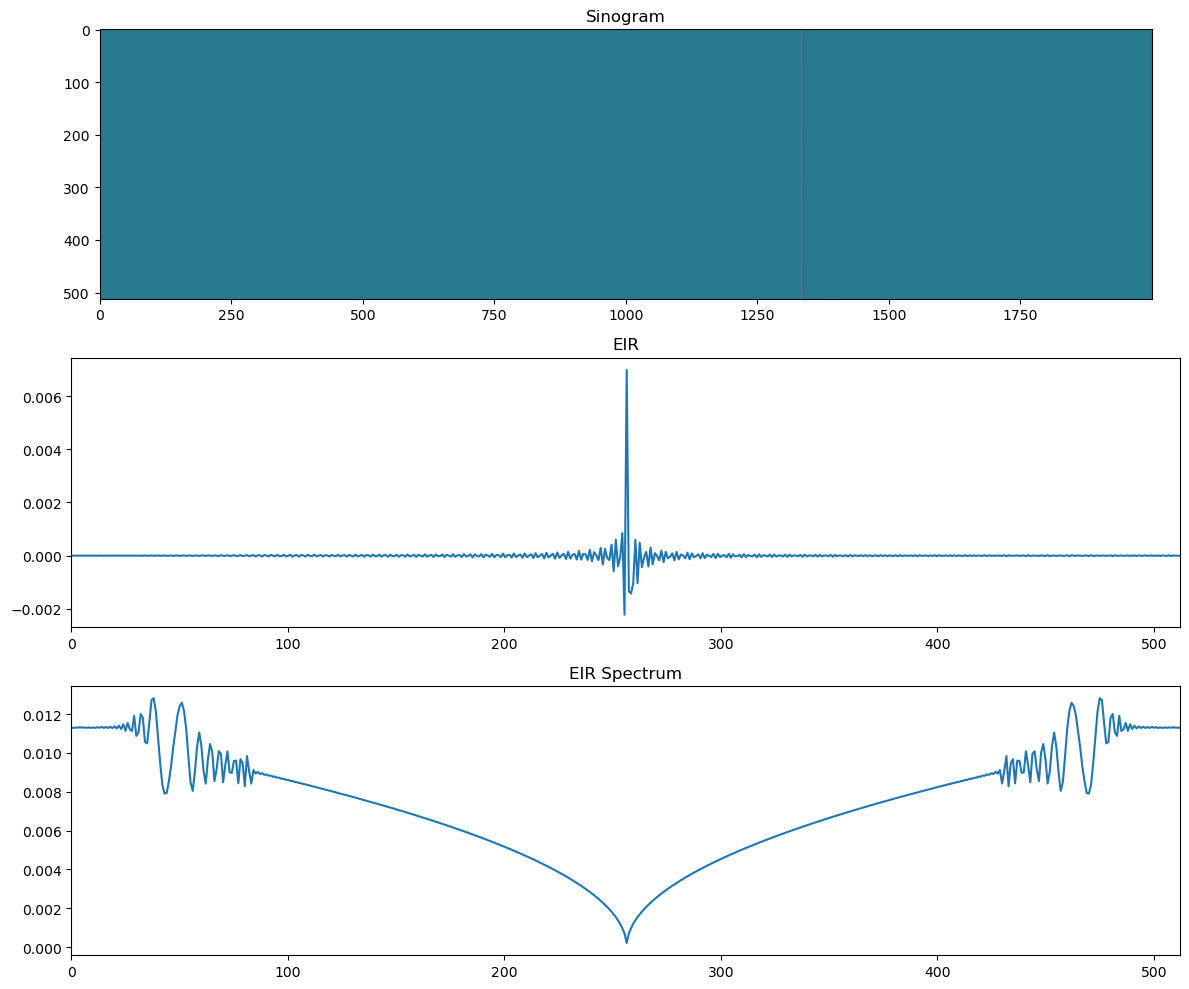

: 

In [22]:
plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
plt.imshow(sensor_data)
plt.title('Sinogram')

plt.subplot(3,1,2)
plt.plot(times, np.squeeze(EIR_crop))
plt.xlim(0, 512)
plt.title('EIR')

plt.subplot(3,1,3)
plt.plot(times, np.squeeze(sinogram_ft))
plt.xlim(0, 512)
plt.title('EIR Spectrum')
plt.tight_layout()